# 05 - Pix2Pix Inference

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# from botocore.exceptions import ClientError
# import boto3
# import calendar
# import io
# from itertools import product
# import numpy as np
import os
import pandas as pd
# import random
# import tifffile as tif
# from tqdm import tqdm

import torch
import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

# from models.pix2pix_model import Pix2PixModel

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
class Options():
    def __init__(self, is_train=False):
        # basic parameters
        self.name = 'biomassters' # name of the experiment. It decides where to store samples and models
        self.dataroot = 'data'
        self.gpu_ids = -1,  # gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU
        self.checkpoints_dir = './checkpoints' # models are saved here
        
        # dataset parameters
        self.dataset_mode = 'biomassters' # chooses how datasets are loaded. [unaligned | aligned | single | colorization]
        self.direction = 'AtoB' # AtoB or BtoA
        self.preprocess = '' # scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]
        self.crop_size = 256
        self.no_flip = True
        self.max_dataset_size = 10
        
        # test parameters
        self.num_test = 50

        # train parameters
        self.isTrain = is_train # train or test
        self.eval = False if is_train else True
        self.lr_policy = 'linear' # learning rate policy. [linear | step | plateau | cosine]
        self.lambda_L1 = 100. # 'weight for L1 loss'
        self.gan_mode = 'vanilla' # the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.
        self.beta1 = .5 # momentum term of adam
        self.pool_size = 0 # the size of image buffer that stores previously generated images [TRAIN]
        self.lr = 0.0002 # initial learning rate for adam
        self.n_epochs=100 # umber of epochs with the initial learning rate'
        
        # train parameters - network saving and loading
        self.continue_train = False # continue training: load the latest model
        self.epoch_count=1 # the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
        self.n_epochs_decay=100 #number of epochs with the initial learning rate
        
        # model parameters
        # Common
        self.model = 'pix2pix' 
        self.input_nc = 180 # # of input image channels: 3 for RGB and 1 for grayscale
        self.output_nc = 1 # # of output image channels: 3 for RGB and 1 for grayscale 
        self.norm = 'batch' # instance normalization or batch normalization [instance | batch | none]
        self.init_type = 'normal' # network initialization [normal | xavier | kaiming | orthogonal]
        self.init_gain = 0.02 # scaling factor for normal, xavier and orthogonal.

        # Generator
        self.ngf = 64 # # of gen filters in the last conv layer
        self.netG = 'unet_256' # specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]
        self.no_dropout = 'store_true' # no dropout for the generator
        
        # Discriminator
        self.ndf = 64 # # of discrim filters in the first conv layer
        self.netD = 'basic' # specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator
        self.n_layers_D = 3 # only used if netD==n_layers
        
        # Additional
        self.load_iter = 0 # which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]
        self.epoch = 'latest' # which epoch to load? set to latest to use latest cached model
        self.verbose = True # if specified, print more debugging information

        

In [3]:
from pix2pix.data import create_dataset
from pix2pix.models import create_model
from pix2pix.util.visualizer import save_images
from pix2pix.util import html

opt = Options(is_train=True)
opt.num_threads = 0   # test code only supports num_threads = 0
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.verbose = False
# test
opt.results_dir = './results/'
opt.phase = 'test'
opt.aspect_ratio = 1.0
opt.display_winsize = 256
opt.use_wandb = False

dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)

/Users/loaner/.pyenv/versions/3.8.15/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dataset [BioMasstersDataset] was created
initialize network with normal
initialize network with normal
model [Pix2PixModel] was created
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.591 M
[Network D] Total number of parameters : 2.948 M
-----------------------------------------------


In [4]:
# create a website
web_dir = os.path.join(opt.results_dir, opt.name, '{}_{}'.format(opt.phase, opt.epoch))  # define the website directory
if opt.load_iter > 0:  # load_iter is 0 by default
    web_dir = '{:s}_iter{:d}'.format(web_dir, opt.load_iter)
print('creating web directory', web_dir)
webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.epoch))

creating web directory ./results/biomassters/test_latest


In [16]:
if opt.eval:
    model.eval()
visuals_dict = {}
for i, data in enumerate(dataset):
    if i >= opt.num_test:  # only apply our model to opt.num_test images.
        break
    model.set_input(data)  # unpack data from data loader
    model.test()           # run inference
    visuals = model.get_current_visuals()  # get image results
    img_path = model.get_image_paths()     # get image paths
    if i % 1 == 0:  # save images to an HTML file
        print('processing (%04d)-th image... %s' % (i, img_path))
    visuals_dict[img_path[0]] = visuals
    save_images(webpage, visuals, img_path, aspect_ratio=opt.aspect_ratio, width=opt.display_winsize, use_wandb=opt.use_wandb, is_tif=True)
webpage.save()  # save the HTML


processing (0000)-th image... ['A_095cdde6']
processing (0001)-th image... ['A_ba735cb5']
processing (0002)-th image... ['A_f824d7f4']
processing (0003)-th image... ['A_31bca177']
processing (0004)-th image... ['A_b6fb3139']
processing (0005)-th image... ['A_7fa31df6']
processing (0006)-th image... ['A_b938b95f']
processing (0007)-th image... ['A_c7979d63']
processing (0008)-th image... ['A_f2591902']
processing (0009)-th image... ['A_8f05489d']


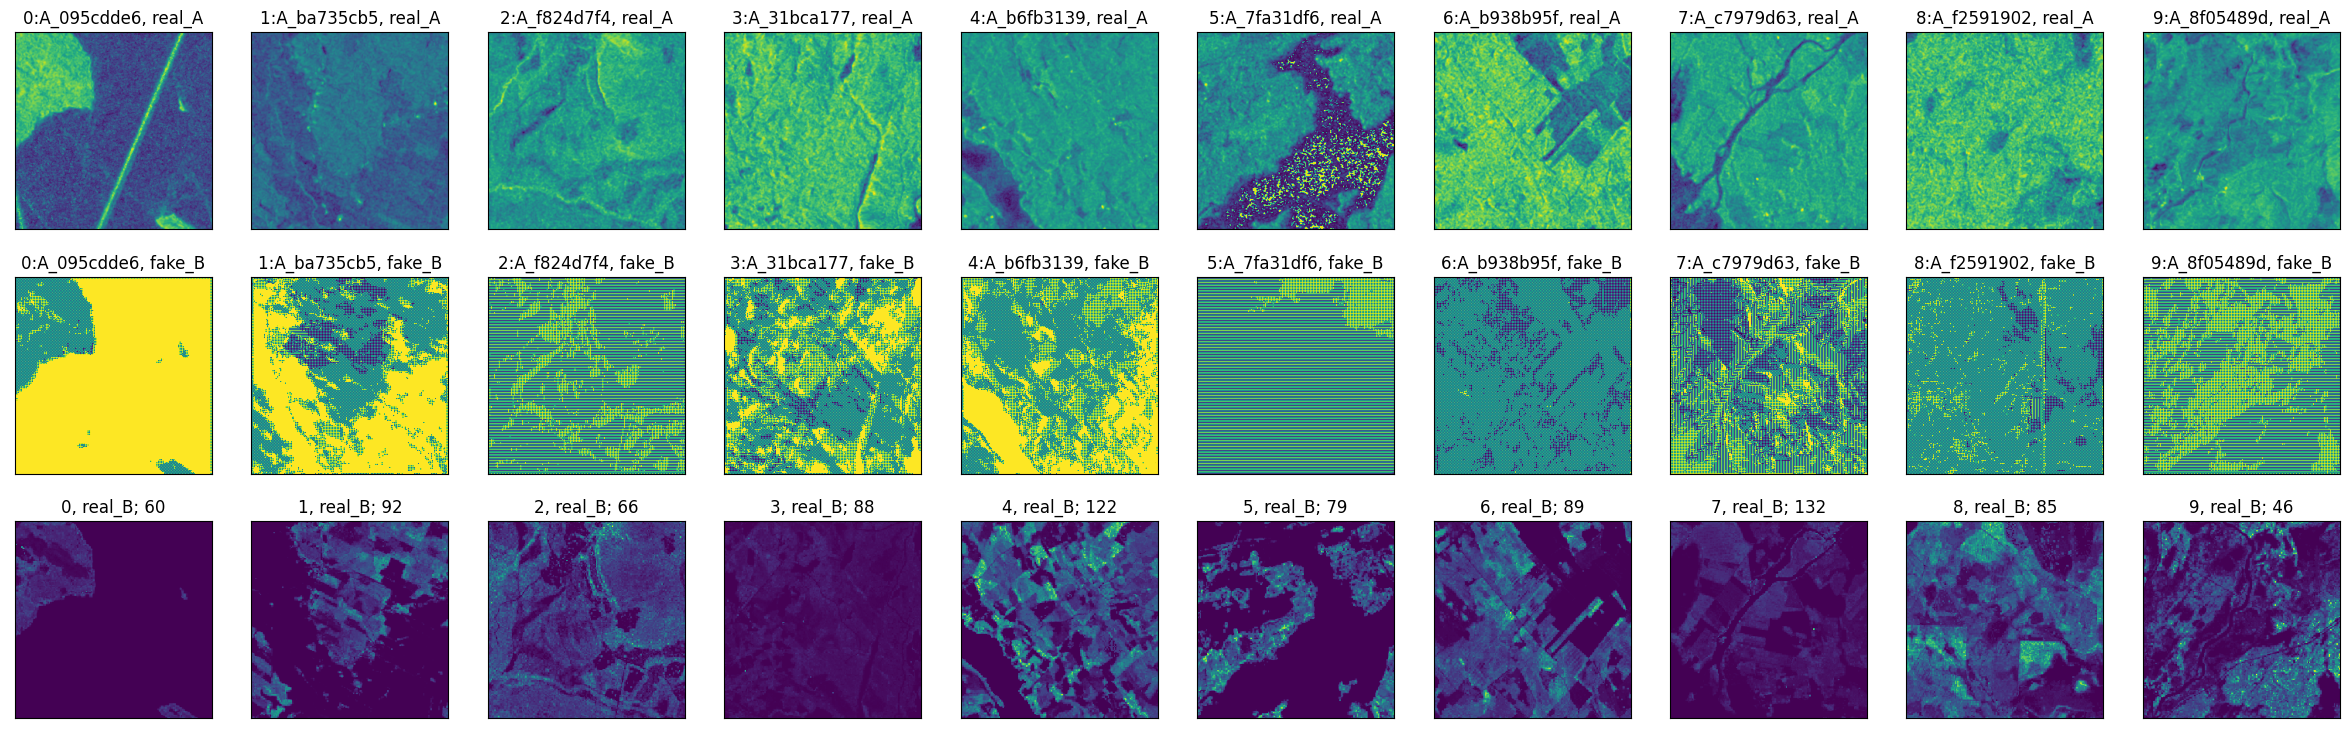

In [18]:
num_steps = 1
batch_size = len(visuals_list)
channel = 0
criterion = nn.MSELoss()

fig, axes = plt.subplots(nrows=3*num_steps, ncols=batch_size, figsize=(3*batch_size,9*num_steps))
axes = axes.flatten()

# j = 0
for j, (chip_id, visuals) in enumerate(visuals_dict.items()):
    a, b, b_fake = visuals['real_A'][0], visuals['real_B'][0], visuals['fake_B'][0]

    data = {
        'real_A': a[channel,:,:],
        'fake_B': b_fake[0,:,:],
        'real_B': b[0,:,:],
    }
    rmse = torch.sqrt(criterion(b, b_fake))

    for k, (title, img) in enumerate(data.items()):
        idx = j+k*batch_size
        axes[idx].imshow(img)
        axes[idx].set_title(f'{j}:{chip_id}, {title}')
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
    axes[idx].set_title(f'{j}, {title}; RMSE: {rmse.item():.0f}')


## Create train, validation, test splits

In [42]:
from sklearn.model_selection import train_test_split
RANDOM_STATE=42

In [52]:
df_metadata = pd.read_csv("data/metadata/features_metadata.csv",index_col=0)
all_chips = list(df_metadata.chip_id.unique())
train_chips = list(df_metadata[df_metadata.split=='train'].chip_id.unique())
test_chips = list(df_metadata[df_metadata.split=='test'].chip_id.unique())

df_metadata_train = df_metadata[df_metadata.split=='train'].chip_id \
    .drop_duplicates().reset_index(drop=True).to_frame()

X_train, X_validation = train_test_split(df_metadata_train, test_size=0.33, random_state=RANDOM_STATE)
df_metadata.loc[df_metadata.chip_id.isin(X_validation.chip_id), 'split'] = 'validation'
df_metadata.to_csv(f"data/metadata/features_metadata_split_{RANDOM_STATE}.csv")

In [71]:
df=pd.read_csv(f"data/metadata/features_metadata_split_{RANDOM_STATE}.csv", index_col=0)
df.split.value_counts()

train         126505
validation     68832
test           63348
Name: split, dtype: int64

In [69]:
!python ./pix2pix/test.py --dataroot ./data --name biomassters --model pix2pix --direction AtoB --input_nc 180 \
    --dataset_mode biomassters --gpu_ids -1 --results_dir ./results/ --phase validation \
    --max_dataset_size 10 --preprocess "" --no_dropout


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./data                        	[default: data]
             dataset_mode: biomassters                   	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 180                           	[default: 3]
                  isTrain: False                         	[default: None]
           

## Train dev

In [73]:
!python ./pix2pix/train.py --dataroot ./data --name biomassters --model pix2pix --direction AtoB --display_id -1 \
    --input_nc 180 --dataset_mode biomassters --gpu_ids -1 --phase train \
    --max_dataset_size 10 --preprocess ""

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./data                        	[default: data]
             dataset_mode: biomassters                   	[default: aligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest       